In [8]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
API_TOKEN = os.getenv('API_TOKEN')
# print(API_TOKEN)


# 量子ウォーク全体像

今回はサイクル4の量子ウォークを実装する。図は矢印ですが無向グラフです。

![](../img/circle.png)

量子ウォークのダイナミクスを量子回路に埋め込むには以下のように量子ビットに役割を与える

![](../img/qw.png)

全体の系は

$$|\Psi\rangle_{n}=\hat{W}^{\otimes n}|\Psi\rangle_{0}$$

で表せる。

# 初期状態を作成

$$|\Psi\rangle_{0}=|00\rangle\otimes\frac{1}{\sqrt{2}} \begin{bmatrix}1\\i\end{bmatrix}$$

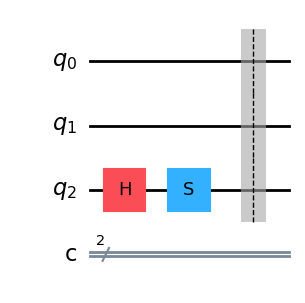

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = QuantumCircuit(3,2)

qc.h(2)
qc.s(2)
qc.barrier()

qc.draw("mpl")

# $\hat{C}$ の定義

さて、続いては実際の量子ウォークの時間発展を量子回路に落とし込んでいく。全体の作用素は次のように定義される。

$$
W=\hat{S}\hat{C}\\
$$

ここで、$\hat{C}$はコイン作用素、$\hat{S}$はシフト作用素であり、それぞれ状態、位置に対して作用する。
$\hat{C}$は状態に作用するため、

$$\hat{C}=I^{\otimes(N-1)} \otimes C$$

ここで、今回のコインは$H$ゲートとするため、

$$C=H$$

とする。

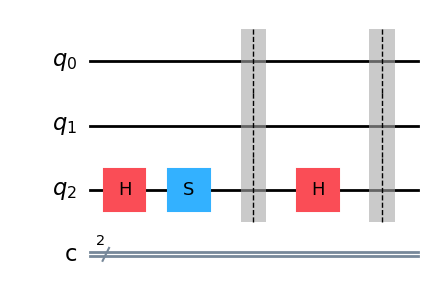

In [2]:
qc.h(2)

qc.barrier()

qc.draw("mpl")

# $\hat{S}$ の定義

続いて$\hat{S}$を実装していく。$\hat{S}$は位置に対して作用し、以下のように定義される。

$$\hat{S} = \sum_{x}|x-1\rangle\langle x|\otimes|0\rangle\langle 0|+|x+1\rangle\langle x|\otimes|1\rangle\langle 1|$$

これは状態が$|0\rangle$の時、位置を$-1$し、$|1\rangle$の時は位置を$+1$することを意味する。
つまり量子回路では、状態が$|0\rangle$の時に減算器、$|1\rangle$の時に加算器を作用させる量子回路を組めばいい。$S$を加算器、$S^{-1}$を減算器として次のように示せる。

![](../img/adder_%20subtractor.png)

問：4 qubitの加算器、減算器に好きな2進数を入力して、$+1, -1$されるか確認せよ。



In [3]:
qc.x(2)
qc.cx(2,1)
qc.ccx(2,1,0)
qc.x(2)

qc.ccx(2,1,0)
qc.cx(2,1)

qc.barrier()

qc.draw("mpl")

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

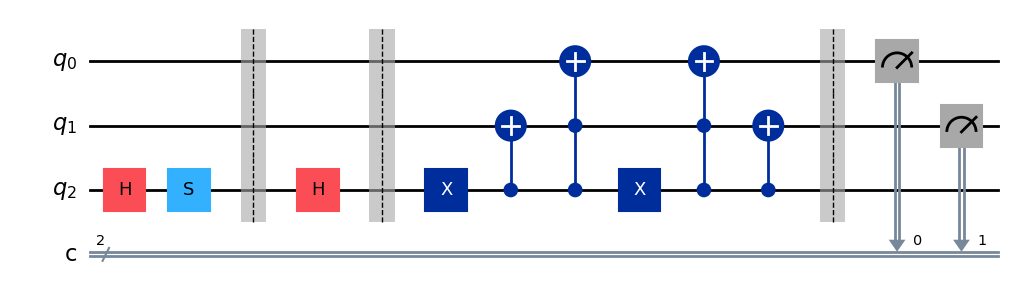

In [4]:
qc.measure(0,0)
qc.measure(1,1)

qc.draw("mpl")

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler
 
sampler = StatevectorSampler()

pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(qc)
# Run using V2 sampler
result = sampler.run([qc]).result()
# Access result data for PUB 0
data_pub = result[0].data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.c.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.c.get_counts()
print(f"The counts are: {counts}")

The number of bitstrings is: 1024
The counts are: {'10': 483, '11': 541}


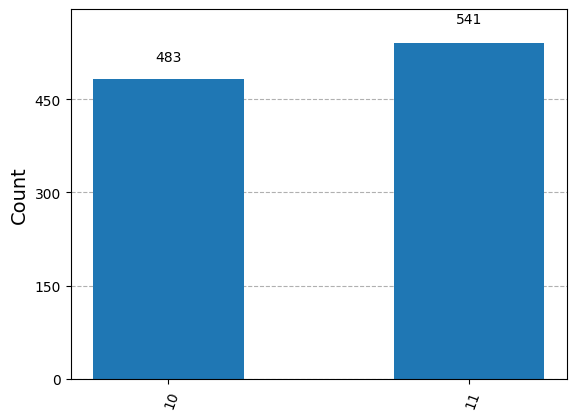

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)